# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [97]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

# student additions
import pandas as pd
import warnings; warnings.simplefilter('ignore')

Load feature names.

In [4]:
feature_names = []
with open('data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print ('Loaded feature names:', len(feature_names))

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [7]:
X, Y = [], []

with open('data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print (train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


## 1) Run Principal Component Analysis
Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

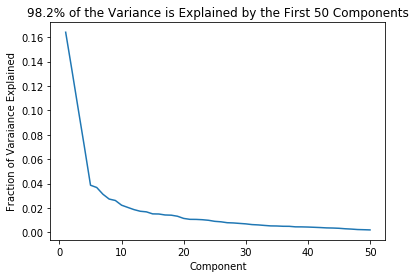

In [38]:
def P1():
    
    # PCA
    n_comp = 50
    pca = PCA(n_components=n_comp)
    pca.fit(train_data)
    plt.plot(list(range(1,n_comp+1)),pca.explained_variance_ratio_)
    
    # formatting
    plt.title("{0:.1f}% of the Variance is Explained by the First {1} Components" \
              .format(sum(pca.explained_variance_ratio_)*100,n_comp))
    plt.ylabel("Fraction of Varaiance Explained")
    plt.xlabel("Component")
    plt.show()

P1()

I took this question to mean show the fraction of the variance explained by each component. If you were looking for the fraction of the varaince explained by by all componenets less than or equal to k, then you would just take the cumsum() of this plot.

## 2) Use PCA to Visualize Mushroom Dataset in Two Dimensions
PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

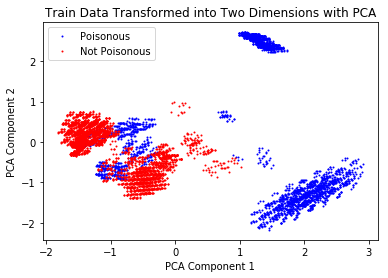

In [88]:
def P2():
    
    # PCA
    n_comp = 2
    pca = PCA(n_components=n_comp)
    train_data_2d = pca.fit_transform(train_data)
    
    # plot - label value of 1 indicates poisonous
    plt.plot(train_data_2d[:,0][train_labels==1], train_data_2d[:,1][train_labels==1], color='blue', marker='.', markersize=2, linestyle='None', label="Poisonous")
    plt.plot(train_data_2d[:,0][train_labels==0], train_data_2d[:,1][train_labels==0], color='red', marker='.', markersize=2, linestyle='None', label="Not Poisonous")
    
    # formatting
    plt.title('Train Data Transformed into Two Dimensions with PCA')
    plt.ylabel('PCA Component 2')
    plt.xlabel('PCA Component 1')
    plt.legend()
    plt.show()

P2()

## 3) Show The Evolution of K-Means from K=1 to K=16
Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

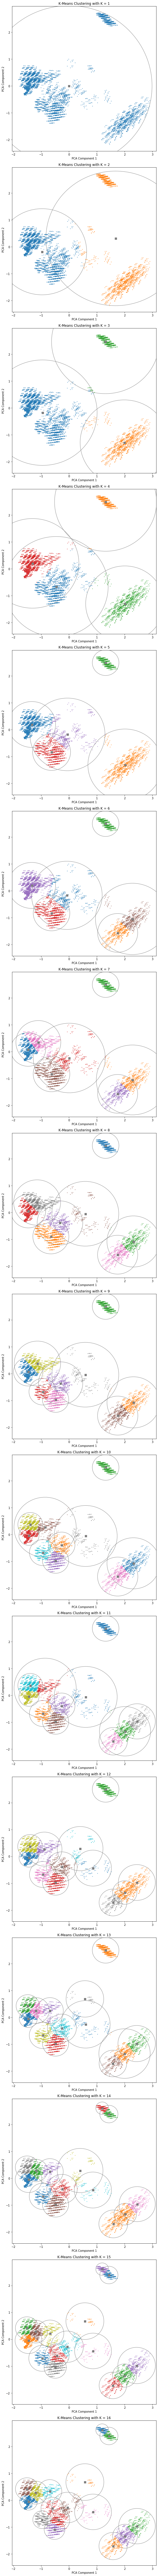

In [87]:
def P3():
    
    # PCA
    n_comp = 2
    n_k = 16
    pca = PCA(n_components=n_comp)
    train_data_2d = pca.fit_transform(train_data)
    
    # subplots
    f,a = plt.subplots(n_k, 1)
    f.set_figwidth(8)
    f.set_figheight(n_k*8)
    
    # put the k in k-means
    for kk in range(1,n_k+1):
        
        # k-means
        km = KMeans(n_clusters=kk)
        train_data_km = km.fit_transform(train_data_2d)
        ax = a[kk-1]
        
        # plot points and circles for each group
        for ind, center in enumerate(km.cluster_centers_):
            
            # points
            #col = np.random.rand(3,1)
            group = km.labels_==ind
            ax.plot(train_data_2d[:,0][group], train_data_2d[:,1][group], marker='.', markersize=2, linestyle='None', label=str(kk))
            ax.plot(center[0], center[1], color='grey', marker='s', markersize=7)
            
            # circles
            radius = np.amax(train_data_km[group,ind])
            circle = plt.Circle(center, radius, color='grey', fill=False)
            ax.add_artist(circle)

        # formatting
        ax.set_title("K-Means Clustering with K = {}" \
            .format(kk))
        ax.set_ylabel('PCA Component 2')
        ax.set_xlabel('PCA Component 1')
        
    # extra formatting
    plt.tight_layout()
    plt.show()

P3()

## 4) Gaussian Mixture Models
Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

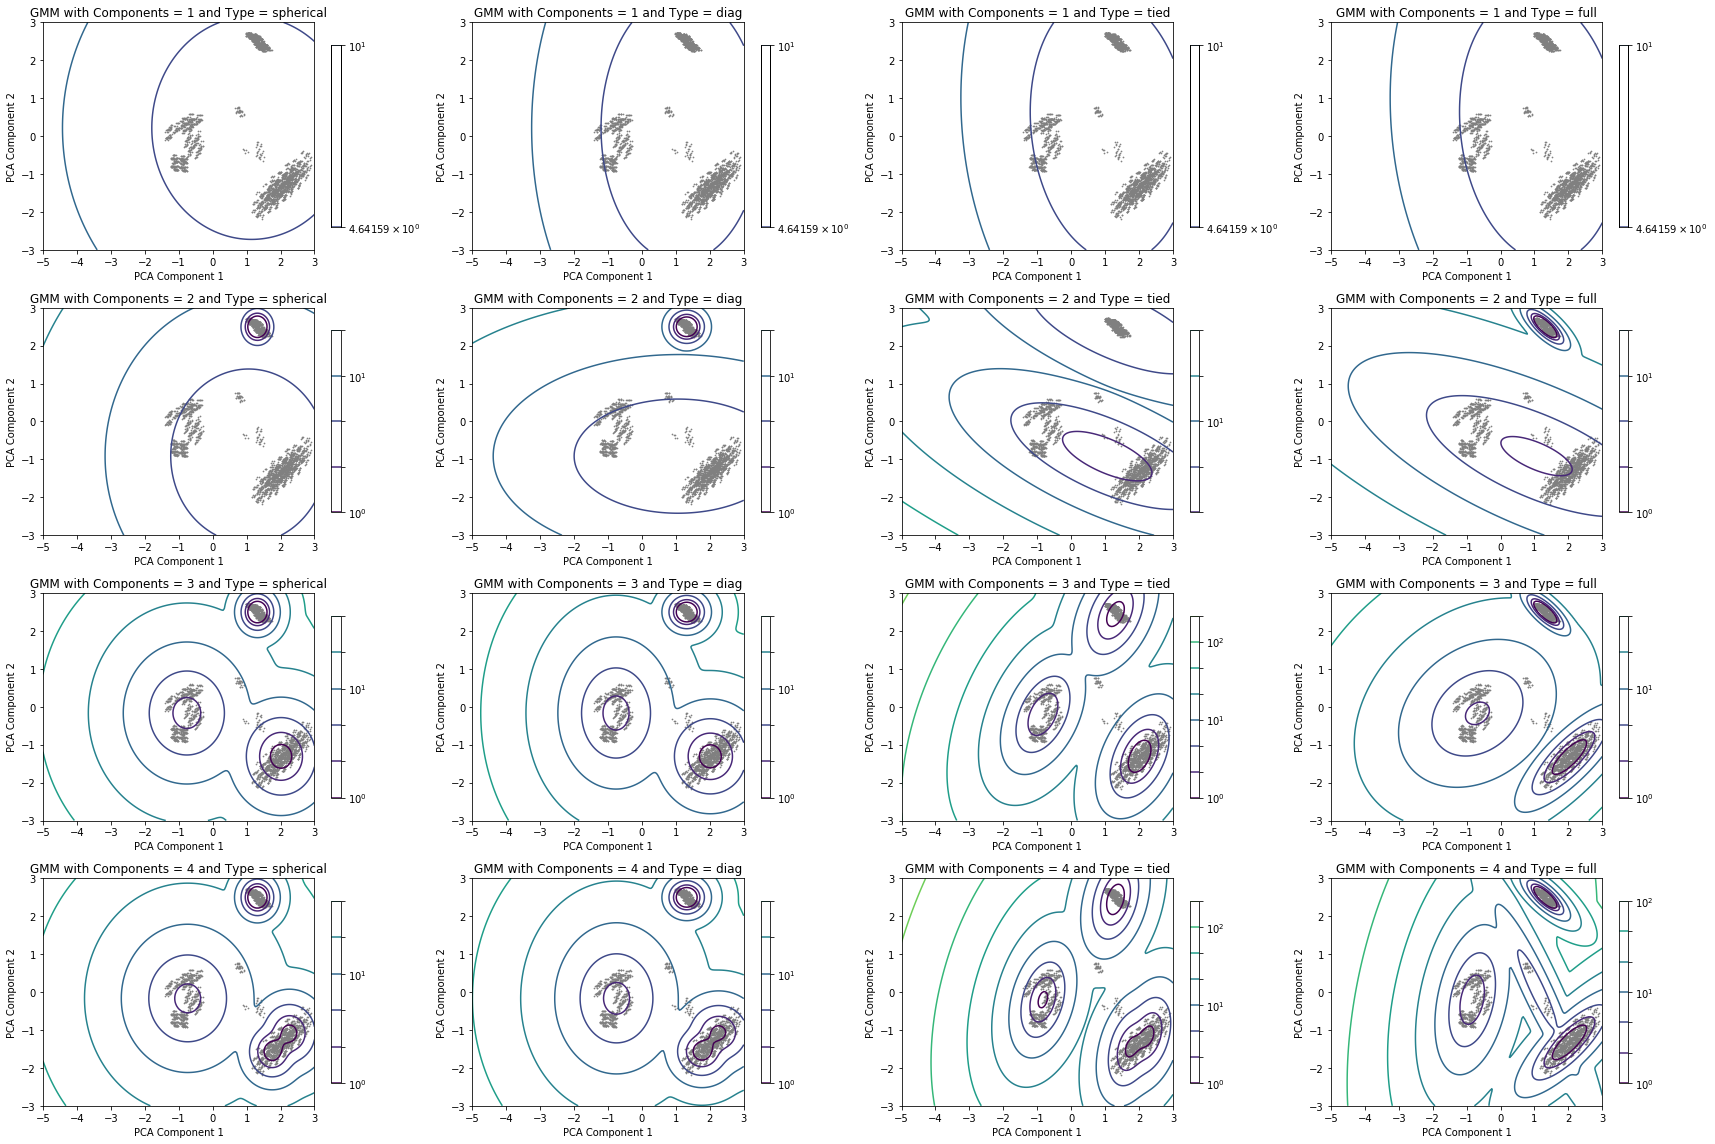

In [103]:
def P4():

    # PCA
    n_comp = 2
    pca = PCA(n_components=n_comp)
    train_data_2d = pca.fit_transform(train_data)
    train_data_2d = train_data_2d[train_labels==1]
    
    # params
    components = list(range(1,5))
    types = ['spherical', 'diag', 'tied', 'full']
    
    # subplots
    f,a = plt.subplots(len(components), len(types))
    f.set_figwidth(len(types)*6)
    f.set_figheight(len(components)*4)
    
    # make a gmm for each permutation of params
    for indc, comp in enumerate(components):
        for indt, typ in enumerate(types):
            
            # GMM
            gmm = GMM(n_components=comp, covariance_type=typ)
            gmm.fit(train_data_2d)

            # 
            x = np.linspace(-5.0, 3.0, 200)
            y = np.linspace(-3.0, 3.0, 200)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gmm.score_samples(XX)[0]
            Z = Z.reshape(X.shape)
            
            # plot
            ax = a[indc,indt]
            CS = ax.contour(X,
                Y,
                Z,
                norm=LogNorm(vmin=1.0, vmax=1000.0),
                levels=np.logspace(0, 3, 10))
            CB = plt.colorbar(CS,
                shrink=0.8,
                extend='both',
                ax=ax)
            ax.scatter(train_data_2d[:, 0], train_data_2d[:, 1], color='grey', marker='.', s=2 , linestyle='None')
            
            # formatting
            ax.set_title("GMM with Components = {} and Type = {}" \
                .format(comp,typ))
            ax.set_ylabel('PCA Component 2')
            ax.set_xlabel('PCA Component 1')
    
    # extra formatting
    plt.tight_layout()
    plt.show()

P4()

## 5) Predict Whether a Mushroom is Poisonous with GNNs
Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [105]:
def P5():

    # PCA
    n_comp = 2
    pca = PCA(n_components=n_comp)
    train_data_2d = pca.fit_transform(train_data)
    test_data_2d = pca.transform(test_data)
    
    # seperate types
    pos = train_data_2d[train_labels==1]
    neg = train_data_2d[train_labels==0]
    
    # params
    best_comp = 4
    best_typ = 'full'
    
    # fit positive model
    gmm_pos = GMM(n_components=best_comp, covariance_type=best_typ)
    gmm_pos.fit(pos)
    prob_pos = gmm_pos.score(test_data_2d)

    # fit negative model
    gmm_neg = GMM(n_components=best_comp, covariance_type=best_typ)
    gmm_neg.fit(neg)
    prob_neg = gmm_neg.score(test_data_2d)
    
    # Calculate prediction and accuracy
    poisonous = prob_pos > prob_neg
    correct = np.equal(poisonous, test_labels)
    print("Accuracy of GNN with Components = {} and Type = {} is {:.2f}%" \
        .format(best_comp,best_typ,np.sum(correct)*100.0/len(correct)))

P5()

Accuracy of GNN with Components = 4 and Type = full is 95.11%


## Find the Best GNN
Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [108]:
def P6():

    # params
    labels = [0,1]
    principal_components = list(range(1,51))
    gnn_types = ['spherical', 'diag', 'tied', 'full']
    gnn_components = list(range(1,51))
    
    # result containers
    params = []
    scores = []
       
    # Iterate over PCA dimensions, covariance marix type, and number of GMM compnents
    for pcomp in principal_components:
        for typ in gnn_types:
            for gcomp in gnn_components:
                
                # calculate params
                # 'spherical' (each component has its own single variance)
                # gmm.covariances_.shape = (gcomp,)
                if typ == gnn_types[0]:
                    n_params = (pcomp + 1) * gcomp * len(labels)
                
                # 'diag' (each component has its own diagonal covariance matrix)
                # gmm.covariances_.shape = (gcomp, pcomp)
                elif typ == gnn_types[1]:
                    n_params = (pcomp + pcomp) * gcomp * len(labels)
                
                # 'tied' (all components share the same general covariance matrix)
                # gmm.covariances_.shape = (pcomp, pcomp)
                elif typ == gnn_types[2]:
                    n_params = (pcomp + pcomp**2) * gcomp * len(labels)
                
                # 'full' (each component has its own general covariance matrix)
                # gmm.covariances_.shape = (gcomp, pcomp, pcomp)
                elif typ == gnn_types[3]:
                    n_params = (pcomp + gcomp*pcomp**2) * gcomp * len(labels)                
                
                if n_params < 50:

                    # PCA
                    pca = PCA(n_components=pcomp)
                    train_data_pca = pca.fit_transform(train_data)
                    test_data_pca = pca.transform(test_data)

                    # seperate types
                    pos = train_data_pca[train_labels==1]
                    neg = train_data_pca[train_labels==0]

                    # fit positive model
                    gmm_pos = GMM(n_components=gcomp, covariance_type=typ)
                    gmm_pos.fit(pos)
                    prob_pos = gmm_pos.score(test_data_pca)

                    # fit negative model
                    gmm_neg = GMM(n_components=gcomp, covariance_type=typ)
                    gmm_neg.fit(neg)
                    prob_neg = gmm_neg.score(test_data_pca)

                    # Calculate prediction and accuracy
                    poisonous = prob_pos > prob_neg
                    correct = np.equal(poisonous, test_labels)
                    accuracy = np.sum(correct)*100.0/len(correct)
                    # too many dimensions to visualize, just printing the results of each run
                    print("Accuracy of GNN with PCA Components = {}, and GNN Type = {} and GNN Components = {} is {:.2f}%" \
                        .format(pcomp,typ,gcomp,accuracy))
                    
                    # add run to containers
                    params.append([pcomp,typ,gcomp,n_params])
                    scores.append(accuracy)
                
    
    max_score = max(scores)
    max_index = scores.index(max_score)
    max_param = params[max_index]
    max_pcomp = max_param[0]
    max_typ = max_param[1]
    max_gcomp = max_param[2]
    max_count = max_param[3]
    print("#########################################################")
    print("Best Classifier Under 50 Params:\n\tPCA Components = {}\n\tGNN Type = {}\n\tGNN Components = {}\n\tNum Parameters = {}\n\tAccuracy = {:.2f}%" \
        .format(max_pcomp,max_typ,max_gcomp,max_count,max_score))
    print("#########################################################")
                
P6()

Accuracy of GNN with PCA Components = 1, and GNN Type = spherical and GNN Components = 1 is 84.43%
Accuracy of GNN with PCA Components = 1, and GNN Type = spherical and GNN Components = 2 is 89.95%
Accuracy of GNN with PCA Components = 1, and GNN Type = spherical and GNN Components = 3 is 90.30%
Accuracy of GNN with PCA Components = 1, and GNN Type = spherical and GNN Components = 4 is 91.37%
Accuracy of GNN with PCA Components = 1, and GNN Type = spherical and GNN Components = 5 is 90.66%
Accuracy of GNN with PCA Components = 1, and GNN Type = spherical and GNN Components = 6 is 90.84%
Accuracy of GNN with PCA Components = 1, and GNN Type = spherical and GNN Components = 7 is 91.19%
Accuracy of GNN with PCA Components = 1, and GNN Type = spherical and GNN Components = 8 is 91.01%
Accuracy of GNN with PCA Components = 1, and GNN Type = spherical and GNN Components = 9 is 91.01%
Accuracy of GNN with PCA Components = 1, and GNN Type = spherical and GNN Components = 10 is 91.10%
Accuracy 

Accuracy of GNN with PCA Components = 5, and GNN Type = diag and GNN Components = 1 is 87.81%
Accuracy of GNN with PCA Components = 5, and GNN Type = diag and GNN Components = 2 is 90.21%
Accuracy of GNN with PCA Components = 6, and GNN Type = spherical and GNN Components = 1 is 87.81%
Accuracy of GNN with PCA Components = 6, and GNN Type = spherical and GNN Components = 2 is 87.99%
Accuracy of GNN with PCA Components = 6, and GNN Type = spherical and GNN Components = 3 is 96.80%
Accuracy of GNN with PCA Components = 6, and GNN Type = diag and GNN Components = 1 is 88.52%
Accuracy of GNN with PCA Components = 6, and GNN Type = diag and GNN Components = 2 is 93.68%
Accuracy of GNN with PCA Components = 7, and GNN Type = spherical and GNN Components = 1 is 87.63%
Accuracy of GNN with PCA Components = 7, and GNN Type = spherical and GNN Components = 2 is 88.08%
Accuracy of GNN with PCA Components = 7, and GNN Type = spherical and GNN Components = 3 is 97.33%
Accuracy of GNN with PCA Compo